In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set print options for cleaner output if needed
np.set_printoptions(precision=3, suppress=True)

In [3]:
from numpy import copy
# from banded.py
def banded(Aa,va,up,down):

    # Copy the inputs and determine the size of the system
    A = copy(Aa)
    v = copy(va)
    N = len(v)

    # Gaussian elimination
    for m in range(N):

        # Normalization factor
        div = A[up,m]

        # Update the vector first
        v[m] /= div
        for k in range(1,down+1):
            if m+k<N:
                v[m+k] -= A[up+k,m]*v[m]

        # Now normalize the pivot row of A and subtract from lower ones
        for i in range(up):
            j = m + up - i
            if j<N:
                A[i,j] /= div
                for k in range(1,down+1):
                    A[i+k,j] -= A[up+k,m]*A[i,j]

    # Backsubstitution
    for m in range(N-2,-1,-1):
        for i in range(up):
            j = m + up - i
            if j<N:
                v[m] -= A[i,j]*v[j]

    return v


In [4]:
# --- Physical Constants ---
mass = 9.109e-31          # Mass of electron (kg)
L = 1e-8                  # Width of the box (m)
hbar = 1.05457e-34        # Planck's constant reduced (J s)
sigma = 1e-10             # Width of wave packet (m)
kappa = 5e10              # Wavenumber (m^-1)
x0 = L / 2                # Center of initial wave packet



N = 10000                  # Number of spatial slices
a = L / N                 # Spatial grid spacing
h = 1e-18                 # Time step (s)

# x points from 0 to L. 
# Interior points (where we solve) are indices 1 to N-1.
x = np.linspace(0, L, N+1) 

# Wavefunction psi(x, 0)
psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * kappa * x)

# Boundary conditions psi = 0 @ x=0 and x=L
psi[0] = 0
psi[N] = 0

# Crank-Nicolson coeffs
# a1, a2 are for Matrix A (LHS)
# b1, b2 are for Matrix B (RHS)
const_term = (1j * h * hbar) / (2 * mass * a**2)

a1 = 1 + const_term
a2 = -const_term / 2
b1 = 1 - const_term
b2 = const_term / 2

# Matrix A for banded
# Size is N-1 (number of interior points)
dim = N - 1

# A_banded has shape (3, dim)
# Row 0: Upper diagonal (starts at index 1 conceptually, so padding required at end? 
# No, banded.py ignores 'dashed' items. 
# Row 0 is [-, A01, A12...] -> [0, a2, a2...]
# Row 1 is [A00, A11...]    -> [a1, a1, a1...]
# Row 2 is [A10, A21...]    -> [a2, a2, ... 0]

A_banded = np.zeros((3, dim), dtype=complex)
A_banded[0, :] = a2 # Upper diag
A_banded[0, 0] = 0
A_banded[1, :] = a1 # Main diag
A_banded[2, :] = a2 # Lower diag
A_banded[2, -1] = 0

In [6]:
steps = 500  # Number of time steps to run
# Store results for plotting (optional, uses memory)
psi_history = []

# Working with interior points only for the linear solve
psi_interior = psi[1:N]

for t in range(steps):
    # Store current state (full vector including boundaries)
    psi_current = np.zeros(N+1, dtype=complex)
    psi_current[1:N] = psi_interior
    psi_history.append(psi_current)
    v = b1 * psi_interior + b2 * (psi_current[2:N+1] + psi_current[0:N-1])
    
    # Solve A * psi(t+h) = v
    psi_interior = banded(A_banded, v, 1, 1)

# Update the final full psi array
psi[1:N] = psi_interior

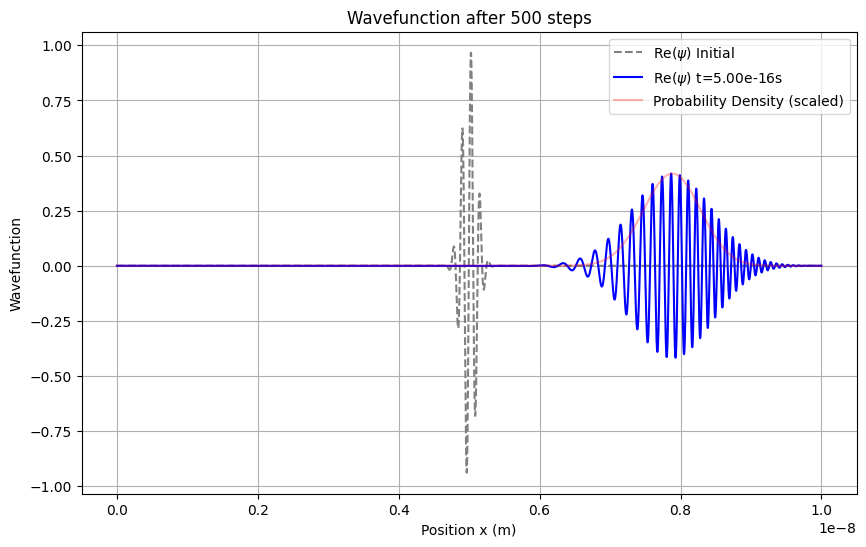

In [7]:
plt.figure(figsize=(10, 6))

# Plot initial condition (Real part)
initial_psi = psi_history[0]
plt.plot(x, np.real(initial_psi), label='Re($\psi$) Initial', color='gray', linestyle='--')

# Plot final state (Real part)
plt.plot(x, np.real(psi), label=f'Re($\psi$) t={steps*h:.2e}s', color='blue')

# Optional: Plot Probability Density (scaled to fit) to show the packet position clearly
density = np.abs(psi)**2
# Scale density for visibility against the real part
scale_factor = np.max(np.real(psi)) / np.max(density)
plt.plot(x, density * scale_factor, label='Probability Density (scaled)', color='red', alpha=0.3)

plt.xlabel('Position x (m)')
plt.ylabel('Wavefunction')
plt.title(f'Wavefunction after {steps} steps')
plt.legend()
plt.grid(True)
plt.show()

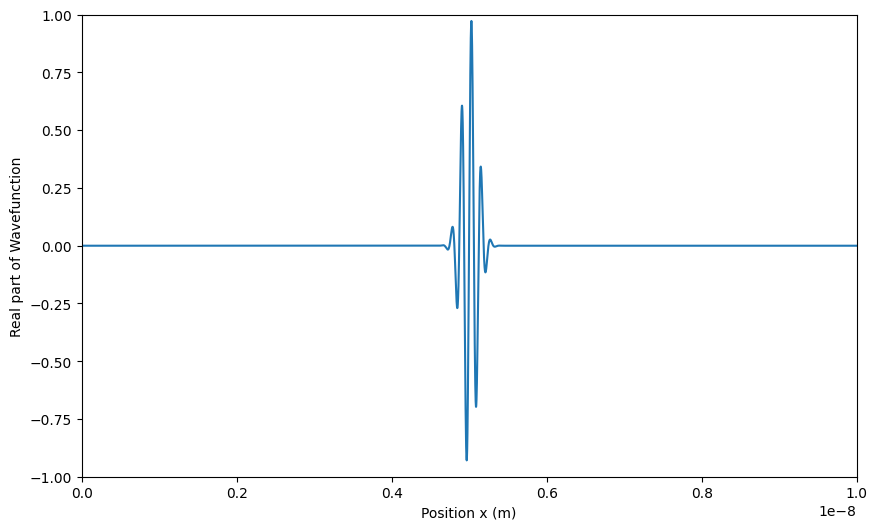

In [8]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # in MB


psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * kappa * x)
psi[0] = 0
psi[N] = 0

fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, np.real(psi))
ax.set_xlim(0, L)
ax.set_ylim(-1.0, 1.0)
ax.set_xlabel("Position x (m)")
ax.set_ylabel("Real part of Wavefunction")

def animate(frame):
    psi_interior = psi[1:N]
    v = b1 * psi_interior + b2 * (psi[2:N+1] + psi[0:N-1])
    psi_interior = banded(A_banded, v, 1, 1)
    psi[1:N] = psi_interior
    line.set_ydata(np.real(psi))
    return line,

skip=50
ani = FuncAnimation(fig, animate, frames=5000, interval=30, blit=True)

In [ ]:
ani.save("wave_animation2.gif", writer="pillow", fps=30)